### Extract File Folders SKU 21 Data (Week 1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

my_data = pd.read_table('competition_data_2023_09_11.csv',delimiter=',')
sku_hist = my_data['sku'].unique()

for sku in sku_hist:
    if sku == "File Folders SKU 21":
        my_data_sku = my_data[my_data["sku"] == sku]

        filepath = Path("0911_my_data_sku_"+sku+".csv")
        filepath.parent.mkdir(parents=True, exist_ok=True)
        my_data_sku.to_csv(filepath, index=False)

sku = "File Folders SKU 21"
path_file = "0911_my_data_sku_"+sku+".csv"
my_data_sku = pd.read_table(path_file,delimiter=',')
print(my_data_sku)

In [ ]:
!pip install skforecast

### Estimate ADSPEND for Week 1

In [ ]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

adspend      = my_data_sku["adspend"].to_numpy()
unitsordered = my_data_sku["unitsordered"].to_numpy()

steps = 9
unitsordered_shifted = np.hstack((np.zeros(steps), unitsordered))

pd_adspend      = pd.Series(adspend)
pd_unitsordered = pd.Series(unitsordered_shifted)
pd_adspend.name = "adspend"
pd_unitsordered.name = "unitsordered"


# Split data into train-test
pd_unitsordered_Tr, pd_unitsordered_Te           = pd_unitsordered[:-steps], pd_unitsordered[-steps:]



# Create and train forecaster
# ==============================================================================
regressor = RandomForestRegressor(max_depth=15, n_estimators=500, random_state=123)


forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 25
             )

forecaster.fit(y=pd_adspend, exog=pd_unitsordered_Tr)


# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=pd_unitsordered_Te)


predictions = np.round(predictions)
print(predictions)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
#pd_adspend_Tr.plot(ax=ax, label='train')
pd_adspend.plot(ax=ax, label='Past Adspend')
predictions.plot(ax=ax, label='Predicted Adspend')
ax.legend();


# ADSPEND_Te = np.array([17,18,15,16,17,16,15,14,14])

### Estimate Competitor's Price for Week 1

In [ ]:
comp_1_price      = my_data_sku["comp_1_price"]
steps             = 9

# Create and train forecaster
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 25
             )
forecaster.fit(y=comp_1_price)


# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

predictions = np.round(predictions, 2)
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
comp_1_price.plot(ax=ax, label='train')
predictions.plot(ax=ax, label='predictions')
ax.legend();


print(predictions)

# comp_1_price_Te = np.array([23.02, 23.13, 23.20, 23.38, 23.75, 25.91, 25.87, 25.86, 25.87])

### Begin Pricing for Week 1

In [22]:
from scipy.spatial.distance import cdist
import cvxpy as cp


def formulate_demand_pmf(price_Tr, comp_1_price_Tr, price_Te0, comp_1_price_Te0, sigma):
    pmf_demand_exponent = (price_Te0 - price_Tr)**2 + (comp_1_price_Te0 - comp_1_price_Tr) ** 2
    pmf_demand = np.exp(-pmf_demand_exponent/sigma)
    pmf_demand = pmf_demand / np.sum(pmf_demand)
    return pmf_demand

def WDRO_demand_calculate(pmf_demand, unitsordered_Tr, price_Te0, epsilon):
    a_1=4.43965609
    a_2=6.60097822
    N = len(pmf_demand)
    cost_hist = 0.85*price_Te0*unitsordered_Tr - (a_1 + a_2) * unitsordered_Tr

    pmf_demand = pmf_demand.reshape([-1,1])
    cost_hist  = cost_hist.reshape([-1,1])
    unitsordered_Tr = unitsordered_Tr.reshape([-1,1])

    cost_unitsordered_Tr = cdist(unitsordered_Tr, unitsordered_Tr, 'sqeuclidean')
    x = cp.Variable(N)
    gamma = cp.Variable([N,N])

    obj = cp.Minimize(cost_hist.T@x)
    constrat = [gamma >=0,
                cp.sum(cp.multiply(gamma, cost_unitsordered_Tr)) <= epsilon,
                cp.sum(gamma,1) == pmf_demand.reshape([-1,]),
                cp.sum(gamma,0) == x]
    prob = cp.Problem(obj,constrat)
    prob.solve()

    #print("Mean Demand: ", np.sum(x.value.reshape([-1,1]) * unitsordered_Tr))
    return x.value, np.sum(x.value.reshape([-1,1]) * cost_hist), np.sum(pmf_demand * cost_hist)

def WDRO_demand_calculate_optimistic(pmf_demand, unitsordered_Tr, price_Te0, epsilon):
    a_1=4.43965609
    a_2=6.60097822
    N = len(pmf_demand)
    cost_hist = 0.85*price_Te0*unitsordered_Tr - (a_1 + a_2) * unitsordered_Tr

    pmf_demand = pmf_demand.reshape([-1,1])
    cost_hist  = cost_hist.reshape([-1,1])
    unitsordered_Tr = unitsordered_Tr.reshape([-1,1])

    cost_unitsordered_Tr = cdist(unitsordered_Tr, unitsordered_Tr, 'sqeuclidean')
    x = cp.Variable(N)
    gamma = cp.Variable([N,N])

    obj = cp.Maximize(cost_hist.T@x)
    constrat = [gamma >=0,
                cp.sum(cp.multiply(gamma, cost_unitsordered_Tr)) <= epsilon,
                cp.sum(gamma,1) == pmf_demand.reshape([-1,]),
                cp.sum(gamma,0) == x]
    prob = cp.Problem(obj,constrat)
    prob.solve()

    #print("Mean Demand: ", np.sum(x.value.reshape([-1,1]) * unitsordered_Tr))


    return x.value, np.sum(x.value.reshape([-1,1]) * cost_hist), np.sum(pmf_demand * cost_hist)


In [23]:
adspend_Tr                 = my_data_sku["adspend"].to_numpy()
profit_Tr                   = my_data_sku["profit"].to_numpy()
unitsordered_Tr            = my_data_sku["unitsordered"].to_numpy()
managed_fba_stock_level_Tr = my_data_sku["managed_fba_stock_level"].to_numpy()
price_Tr                   = my_data_sku["price"].to_numpy()
comp_1_price_Tr            = my_data_sku["comp_1_price"].to_numpy()



idx_hist = np.where(unitsordered_Tr < managed_fba_stock_level_Tr)
idx_Tr   = idx_hist[0]


price_Tr_True        = price_Tr[idx_Tr]
comp_1_price_Tr_True = comp_1_price_Tr[idx_Tr]
unitsordered_Tr_True = unitsordered_Tr[idx_Tr]

sigma = 0.1
epsilon = 5


comp_1_price_Te = np.array([23.02, 23.13, 23.20, 23.38, 23.75, 25.91, 25.87, 25.86, 25.87])
adspend_Te      = np.array([17,18,15,16,17,16,15,14,14])
steps           = len(comp_1_price_Te)
price_Te_hist   = np.load("price_Te_hist.npy")




Profit_history = []
for price_Te in price_Te_hist:
    profit_hist_robust = []
    profit_hist_optimistic = []
    for i in range(steps):
        comp_1_price_Te_i, adspend_Te_i = comp_1_price_Te[i], adspend_Te[i]

        pmf_demand_Tr_Te = formulate_demand_pmf(price_Tr_True, comp_1_price_Tr_True, price_Te, comp_1_price_Te_i, sigma)
        _, profit_robust, _     = WDRO_demand_calculate(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te, epsilon**2)
        _, profit_optimistic, _ = WDRO_demand_calculate_optimistic(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te, epsilon**2)


        profit_hist_robust.append(profit_robust - adspend_Te_i)
        profit_hist_optimistic.append(profit_optimistic - adspend_Te_i)
    print("Price: {}, Robust Profit: {:.2e}, Optimistic Profit: {:.2e}, Width: {:.2e}".format(price_Te,
            np.sum(np.array(profit_hist_robust)), np.sum(np.array(profit_hist_optimistic)), np.sum(np.array(profit_hist_optimistic)) - np.sum(np.array(profit_hist_robust))))
    


    Profit_history.append([np.mean(np.array(profit_hist_robust)), np.mean(np.array(profit_hist_optimistic))])

Profit_history = np.array(Profit_history)





Price: 14.99, Robust Profit: 7.74e+01, Optimistic Profit: 2.30e+02, Width: 1.53e+02
Price: 15.05, Robust Profit: 8.40e+01, Optimistic Profit: 2.42e+02, Width: 1.58e+02
Price: 15.09, Robust Profit: 8.84e+01, Optimistic Profit: 2.49e+02, Width: 1.61e+02
Price: 15.15, Robust Profit: 9.50e+01, Optimistic Profit: 2.60e+02, Width: 1.65e+02
Price: 15.19, Robust Profit: 9.93e+01, Optimistic Profit: 2.68e+02, Width: 1.68e+02
Price: 15.25, Robust Profit: 1.06e+02, Optimistic Profit: 2.79e+02, Width: 1.73e+02
Price: 15.29, Robust Profit: 1.10e+02, Optimistic Profit: 2.86e+02, Width: 1.76e+02
Price: 15.35, Robust Profit: 1.17e+02, Optimistic Profit: 2.98e+02, Width: 1.81e+02
Price: 15.389999999999999, Robust Profit: 1.21e+02, Optimistic Profit: 3.05e+02, Width: 1.84e+02
Price: 15.45, Robust Profit: 1.28e+02, Optimistic Profit: 3.16e+02, Width: 1.88e+02
Price: 15.489999999999998, Robust Profit: 1.32e+02, Optimistic Profit: 3.24e+02, Width: 1.91e+02
Price: 15.549999999999999, Robust Profit: 1.39e+02

In [24]:
Pricing_Record     = np.concatenate([price_Te_hist.reshape([-1,1]),
                                Profit_history], axis=1)

np.savetxt('Week1_pricing.csv', Pricing_Record, delimiter=',', header='Price,Robust,Optimistic', comments='')


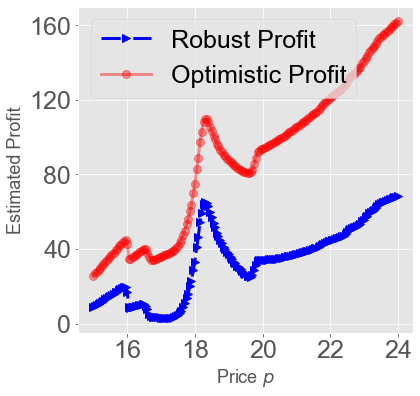

In [43]:
plt.rcParams["font.family"] = "arial"
plt.style.use("ggplot")
fig, axes = plt.subplots(figsize=(6,6))


axes.plot(price_Te_hist, Profit_history[:,0], label=r'Robust Profit', 
            linestyle = '-.', marker = '>', color='blue',ms=8,linewidth=3)
axes.plot(price_Te_hist, Profit_history[:,1], label=r'Optimistic Profit', 
            linestyle = '-', marker = 'o', color='r',ms=8,linewidth=3,alpha=0.4)

axes.legend(loc="best",fontsize=25)
axes.set_xlabel(r'Price $p$', fontsize=18)
axes.set_ylabel(r'Estimated Profit', fontsize=18)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

axes.set_yticks([0,40,80,120,160])
plt.savefig("price_week1.pdf",bbox_anchor="tight")



### Predicted Profit for Week1

In [ ]:
sigma    = 0.1
epsilon  = 5
price_Te = 18.29

profit_hist_robust = []
profit_hist_optimistic = []
for i in range(steps):
    comp_1_price_Te_i, adspend_Te_i = comp_1_price_Te[i], adspend_Te[i]
    
    pmf_demand_Tr_Te = formulate_demand_pmf(price_Tr_True, comp_1_price_Tr_True, price_Te, comp_1_price_Te_i, sigma)
    _, profit_robust, _     = WDRO_demand_calculate(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te, epsilon**2)
    _, profit_optimistic, _ = WDRO_demand_calculate_optimistic(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te, epsilon**2)

    
    profit_hist_robust.append(profit_robust - adspend_Te_i)
    profit_hist_optimistic.append(profit_optimistic - adspend_Te_i)

print(profit_hist_robust)
print(profit_hist_optimistic)